# Multivariate TS analysis - LSTM

> https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

## Data loading and a data cleaning

In [1]:
from pandas import read_csv
from datetime import datetime
from matplotlib import pyplot

# load data
def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')

dataset = read_csv('../../data/raw-polution.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
dataset.drop('No', axis=1, inplace=True)
# manually specify column names
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'
# mark all NA values with 0
dataset['pollution'].fillna(0, inplace=True)
# drop the first 24 hours
dataset = dataset[24:]
# summarize first 5 rows
print(dataset.head(5))
# save to file
dataset.to_csv('pollution.csv')

                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1     0
2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2     0


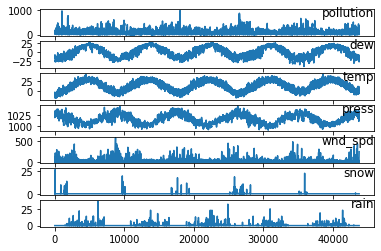

In [2]:
# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
# plot each column
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()

## Data processing

In [3]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
 
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 
# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.129779   0.352941   0.245902   0.527273   0.666667   0.002290   
2   0.148893   0.367647   0.245902   0.527273   0.666667   0.003811   
3   0.159960   0.426471   0.229508   0.545454   0.666667   0.005332   
4   0.182093   0.485294   0.229508   0.563637   0.666667   0.008391   
5   0.138833   0.485294   0.229508   0.563637   0.666667   0.009912   

   var7(t-1)  var8(t-1)   var1(t)  
1   0.000000        0.0  0.148893  
2   0.000000        0.0  0.159960  
3   0.000000        0.0  0.182093  
4   0.037037        0.0  0.138833  
5   0.074074        0.0  0.109658  


In [4]:
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8760, 1, 8) (8760,) (35039, 1, 8) (35039,)


## Model design

In [11]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/50
122/122 - 4s - loss: 0.0559 - val_loss: 0.0552 - 4s/epoch - 36ms/step
Epoch 2/50
122/122 - 4s - loss: 0.0409 - val_loss: 0.0564 - 4s/epoch - 29ms/step
Epoch 3/50
122/122 - 4s - loss: 0.0264 - val_loss: 0.0474 - 4s/epoch - 30ms/step
Epoch 4/50
122/122 - 4s - loss: 0.0192 - val_loss: 0.0423 - 4s/epoch - 29ms/step
Epoch 5/50
122/122 - 3s - loss: 0.0170 - val_loss: 0.0339 - 3s/epoch - 24ms/step
Epoch 6/50
122/122 - 4s - loss: 0.0157 - val_loss: 0.0248 - 4s/epoch - 29ms/step
Epoch 7/50
122/122 - 4s - loss: 0.0149 - val_loss: 0.0183 - 4s/epoch - 29ms/step
Epoch 8/50
122/122 - 3s - loss: 0.0148 - val_loss: 0.0164 - 3s/epoch - 28ms/step
Epoch 9/50
122/122 - 4s - loss: 0.0147 - val_loss: 0.0156 - 4s/epoch - 30ms/step
Epoch 10/50
122/122 - 4s - loss: 0.0147 - val_loss: 0.0155 - 4s/epoch - 29ms/step
Epoch 11/50
122/122 - 4s - loss: 0.0147 - val_loss: 0.0152 - 4s/epoch - 30ms/step
Epoch 12/50
122/122 - 3s - loss: 0.0146 - val_loss: 0.0144 - 3s/epoch - 29ms/step
Epoch 13/50
122/122 - 4s 

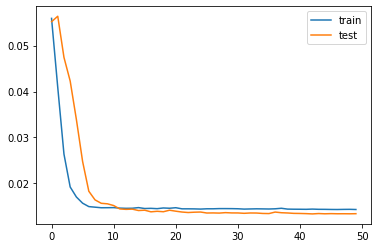

Test RMSE: 26.431


In [12]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
 
# make a prediction
yhat = model.predict(test_X)
test_X_reshaped = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X_reshaped[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y_reshaped = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y_reshaped, test_X_reshaped[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

## Model tweaking

### Loss function

#### MSE

In [7]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/50
122/122 - 4s - loss: 0.0074 - val_loss: 0.0094 - 4s/epoch - 36ms/step
Epoch 2/50
122/122 - 4s - loss: 0.0047 - val_loss: 0.0129 - 4s/epoch - 32ms/step
Epoch 3/50
122/122 - 4s - loss: 0.0028 - val_loss: 0.0146 - 4s/epoch - 34ms/step
Epoch 4/50
122/122 - 4s - loss: 0.0018 - val_loss: 0.0123 - 4s/epoch - 33ms/step
Epoch 5/50
122/122 - 3s - loss: 0.0014 - val_loss: 0.0094 - 3s/epoch - 25ms/step
Epoch 6/50
122/122 - 2s - loss: 0.0012 - val_loss: 0.0071 - 2s/epoch - 20ms/step
Epoch 7/50
122/122 - 3s - loss: 0.0011 - val_loss: 0.0056 - 3s/epoch - 21ms/step
Epoch 8/50
122/122 - 1s - loss: 0.0010 - val_loss: 0.0047 - 937ms/epoch - 8ms/step
Epoch 9/50
122/122 - 2s - loss: 0.0010 - val_loss: 0.0041 - 2s/epoch - 18ms/step
Epoch 10/50
122/122 - 3s - loss: 9.9130e-04 - val_loss: 0.0037 - 3s/epoch - 27ms/step
Epoch 11/50
122/122 - 3s - loss: 9.8447e-04 - val_loss: 0.0034 - 3s/epoch - 21ms/step
Epoch 12/50
122/122 - 2s - loss: 9.7963e-04 - val_loss: 0.0032 - 2s/epoch - 18ms/step
Epoch 13/50

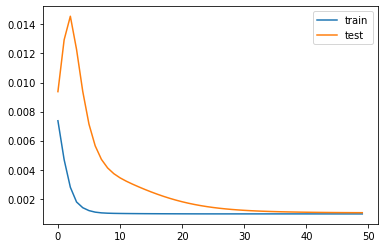

Test RMSE: 32.022


In [8]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
 
# make a prediction
yhat = model.predict(test_X)
test_X_reshaped = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X_reshaped[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y_reshaped = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y_reshaped, test_X_reshaped[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

#### Binary Cross-Entropy

In [9]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='binary_crossentropy', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/50
122/122 - 5s - loss: 0.3572 - val_loss: 0.3212 - 5s/epoch - 42ms/step
Epoch 2/50
122/122 - 4s - loss: 0.3251 - val_loss: 0.3192 - 4s/epoch - 33ms/step
Epoch 3/50
122/122 - 4s - loss: 0.3229 - val_loss: 0.3174 - 4s/epoch - 33ms/step
Epoch 4/50
122/122 - 4s - loss: 0.3210 - val_loss: 0.3160 - 4s/epoch - 32ms/step
Epoch 5/50
122/122 - 4s - loss: 0.3195 - val_loss: 0.3149 - 4s/epoch - 33ms/step
Epoch 6/50
122/122 - 3s - loss: 0.3184 - val_loss: 0.3141 - 3s/epoch - 28ms/step
Epoch 7/50
122/122 - 4s - loss: 0.3175 - val_loss: 0.3135 - 4s/epoch - 32ms/step
Epoch 8/50
122/122 - 4s - loss: 0.3168 - val_loss: 0.3128 - 4s/epoch - 33ms/step
Epoch 9/50
122/122 - 4s - loss: 0.3161 - val_loss: 0.3121 - 4s/epoch - 33ms/step
Epoch 10/50
122/122 - 4s - loss: 0.3154 - val_loss: 0.3114 - 4s/epoch - 33ms/step
Epoch 11/50
122/122 - 4s - loss: 0.3147 - val_loss: 0.3107 - 4s/epoch - 31ms/step
Epoch 12/50
122/122 - 3s - loss: 0.3141 - val_loss: 0.3100 - 3s/epoch - 25ms/step
Epoch 13/50
122/122 - 1s 

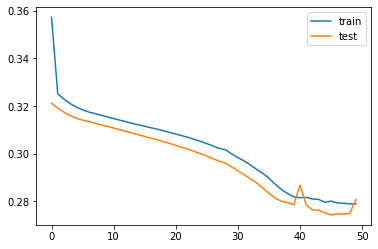

Test RMSE: 44.870


In [10]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
 
# make a prediction
yhat = model.predict(test_X)
test_X_reshaped = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X_reshaped[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y_reshaped = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y_reshaped, test_X_reshaped[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

#### Results

We'll stay with the original mean_absolute_error loss function because results are a lot better.

### Numbers of epoch

#### 25 epochs

In [14]:
nbr_epoch = 25

In [15]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=nbr_epoch, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/25
122/122 - 4s - loss: 0.0563 - val_loss: 0.0651 - 4s/epoch - 31ms/step
Epoch 2/25
122/122 - 4s - loss: 0.0403 - val_loss: 0.0667 - 4s/epoch - 29ms/step
Epoch 3/25
122/122 - 3s - loss: 0.0251 - val_loss: 0.0587 - 3s/epoch - 28ms/step
Epoch 4/25
122/122 - 3s - loss: 0.0187 - val_loss: 0.0523 - 3s/epoch - 27ms/step
Epoch 5/25
122/122 - 4s - loss: 0.0165 - val_loss: 0.0371 - 4s/epoch - 29ms/step
Epoch 6/25
122/122 - 4s - loss: 0.0154 - val_loss: 0.0245 - 4s/epoch - 29ms/step
Epoch 7/25
122/122 - 4s - loss: 0.0151 - val_loss: 0.0222 - 4s/epoch - 29ms/step
Epoch 8/25
122/122 - 3s - loss: 0.0150 - val_loss: 0.0196 - 3s/epoch - 27ms/step
Epoch 9/25
122/122 - 3s - loss: 0.0148 - val_loss: 0.0181 - 3s/epoch - 28ms/step
Epoch 10/25
122/122 - 4s - loss: 0.0149 - val_loss: 0.0173 - 4s/epoch - 29ms/step
Epoch 11/25
122/122 - 4s - loss: 0.0147 - val_loss: 0.0164 - 4s/epoch - 29ms/step
Epoch 12/25
122/122 - 4s - loss: 0.0148 - val_loss: 0.0160 - 4s/epoch - 29ms/step
Epoch 13/25
122/122 - 4s 

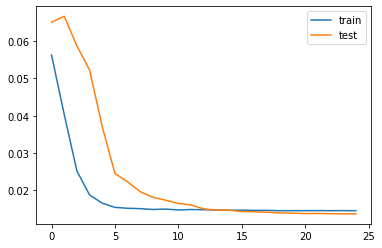

Test RMSE: 26.643


In [16]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
 
# make a prediction
yhat = model.predict(test_X)
test_X_reshaped = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X_reshaped[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y_reshaped = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y_reshaped, test_X_reshaped[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

#### 75 epochs

In [17]:
nbr_epoch = 75

In [18]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=nbr_epoch, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/75
122/122 - 4s - loss: 0.0526 - val_loss: 0.0625 - 4s/epoch - 32ms/step
Epoch 2/75
122/122 - 4s - loss: 0.0375 - val_loss: 0.0619 - 4s/epoch - 29ms/step
Epoch 3/75
122/122 - 4s - loss: 0.0233 - val_loss: 0.0503 - 4s/epoch - 29ms/step
Epoch 4/75
122/122 - 4s - loss: 0.0178 - val_loss: 0.0449 - 4s/epoch - 29ms/step
Epoch 5/75
122/122 - 4s - loss: 0.0162 - val_loss: 0.0315 - 4s/epoch - 29ms/step
Epoch 6/75
122/122 - 4s - loss: 0.0153 - val_loss: 0.0215 - 4s/epoch - 29ms/step
Epoch 7/75
122/122 - 4s - loss: 0.0151 - val_loss: 0.0184 - 4s/epoch - 29ms/step
Epoch 8/75
122/122 - 4s - loss: 0.0148 - val_loss: 0.0169 - 4s/epoch - 29ms/step
Epoch 9/75
122/122 - 4s - loss: 0.0147 - val_loss: 0.0155 - 4s/epoch - 29ms/step
Epoch 10/75
122/122 - 4s - loss: 0.0147 - val_loss: 0.0155 - 4s/epoch - 29ms/step
Epoch 11/75
122/122 - 4s - loss: 0.0148 - val_loss: 0.0150 - 4s/epoch - 29ms/step
Epoch 12/75
122/122 - 4s - loss: 0.0146 - val_loss: 0.0147 - 4s/epoch - 29ms/step
Epoch 13/75
122/122 - 4s 

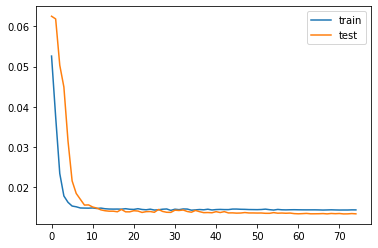

Test RMSE: 26.312


In [19]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
 
# make a prediction
yhat = model.predict(test_X)
test_X_reshaped = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X_reshaped[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y_reshaped = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y_reshaped, test_X_reshaped[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

#### 100 epochs

In [20]:
nbr_epoch = 100

In [21]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=nbr_epoch, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/100
122/122 - 4s - loss: 0.0619 - val_loss: 0.0556 - 4s/epoch - 35ms/step
Epoch 2/100
122/122 - 4s - loss: 0.0422 - val_loss: 0.0584 - 4s/epoch - 29ms/step
Epoch 3/100
122/122 - 4s - loss: 0.0264 - val_loss: 0.0490 - 4s/epoch - 29ms/step
Epoch 4/100
122/122 - 4s - loss: 0.0179 - val_loss: 0.0425 - 4s/epoch - 29ms/step
Epoch 5/100
122/122 - 3s - loss: 0.0160 - val_loss: 0.0276 - 3s/epoch - 29ms/step
Epoch 6/100
122/122 - 4s - loss: 0.0151 - val_loss: 0.0184 - 4s/epoch - 29ms/step
Epoch 7/100
122/122 - 4s - loss: 0.0149 - val_loss: 0.0173 - 4s/epoch - 29ms/step
Epoch 8/100
122/122 - 4s - loss: 0.0147 - val_loss: 0.0161 - 4s/epoch - 29ms/step
Epoch 9/100
122/122 - 3s - loss: 0.0148 - val_loss: 0.0154 - 3s/epoch - 27ms/step
Epoch 10/100
122/122 - 2s - loss: 0.0146 - val_loss: 0.0151 - 2s/epoch - 20ms/step
Epoch 11/100
122/122 - 4s - loss: 0.0148 - val_loss: 0.0145 - 4s/epoch - 29ms/step
Epoch 12/100
122/122 - 3s - loss: 0.0145 - val_loss: 0.0145 - 3s/epoch - 29ms/step
Epoch 13/100


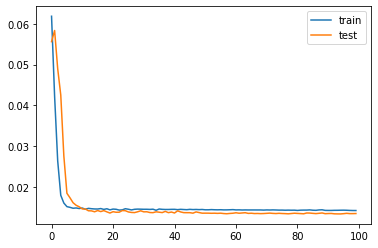

Test RMSE: 26.543


In [22]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
 
# make a prediction
yhat = model.predict(test_X)
test_X_reshaped = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X_reshaped[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y_reshaped = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y_reshaped, test_X_reshaped[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

#### Results

We'll stay with an epoch of 25 to optimize time

In [ ]:
### 

### Model design

#### 2 LSTM + Dropouts

In [4]:
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8760, 1, 8) (8760,) (35039, 1, 8) (35039,)


In [27]:
nbr_epoch = 25

In [29]:
n_steps = train_X.shape[1]
n_features = train_X.shape[2]

print('steps', n_steps, 'features', n_features)

steps 1 features 8


In [30]:
# design network
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(n_steps, n_features)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=nbr_epoch, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/25
122/122 - 10s - loss: 0.0684 - val_loss: 0.0653 - 10s/epoch - 82ms/step
Epoch 2/25
122/122 - 7s - loss: 0.0665 - val_loss: 0.0642 - 7s/epoch - 60ms/step
Epoch 3/25
122/122 - 7s - loss: 0.0646 - val_loss: 0.0621 - 7s/epoch - 61ms/step
Epoch 4/25
122/122 - 7s - loss: 0.0621 - val_loss: 0.0642 - 7s/epoch - 61ms/step
Epoch 5/25
122/122 - 7s - loss: 0.0604 - val_loss: 0.0642 - 7s/epoch - 60ms/step
Epoch 6/25
122/122 - 7s - loss: 0.0597 - val_loss: 0.0635 - 7s/epoch - 60ms/step
Epoch 7/25
122/122 - 7s - loss: 0.0594 - val_loss: 0.0634 - 7s/epoch - 60ms/step
Epoch 8/25
122/122 - 5s - loss: 0.0591 - val_loss: 0.0629 - 5s/epoch - 38ms/step
Epoch 9/25
122/122 - 6s - loss: 0.0591 - val_loss: 0.0627 - 6s/epoch - 52ms/step
Epoch 10/25
122/122 - 8s - loss: 0.0590 - val_loss: 0.0621 - 8s/epoch - 61ms/step
Epoch 11/25
122/122 - 8s - loss: 0.0590 - val_loss: 0.0621 - 8s/epoch - 62ms/step
Epoch 12/25
122/122 - 7s - loss: 0.0589 - val_loss: 0.0618 - 7s/epoch - 60ms/step
Epoch 13/25
122/122 - 7

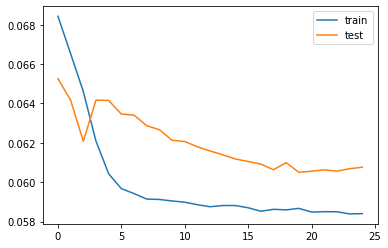

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 1 has 2 dimension(s)

In [31]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
 
# make a prediction
yhat = model.predict(test_X)
test_X_reshaped = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X_reshaped[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y_reshaped = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y_reshaped, test_X_reshaped[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)